# Quantization Aware Training with NNCF, using TensorFlow framework

The goal of this notebook to demonstrate how to use the Neural Network Compression Framework [NNCF](https://github.com/openvinotoolkit/nncf) 8-bit quantization to optimize a TensorFlow model for inference with OpenVINO Toolkit. The optimization process contains the following steps:
* Transform the original FP32 model to INT8
* Use fine-tuning to restore the accuracy
* Export optimized and original models to Frozen Graph and then to OpenVINO
* Measure and compare the performance of models

For more advanced usage, please refer to these [examples](https://github.com/openvinotoolkit/nncf/tree/develop/examples).

We selected the ResNet-18 model with Imagenette dataset. Imagenette is a subset of 10 easily classified classes from the Imagenet dataset. Using the smaller model and dataset will speed up training and download time.

## Imports and Settings

Import NNCF and all auxiliary packages from your Python* code.
Set a name for the model, input image size, used batch size, and the learning rate. Also define paths where Frozen Graph and OpenVINO IR versions of the models will be stored.

In [25]:
from pathlib import Path
import logging

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.keras import backend
from tensorflow.python.keras import layers
from tensorflow.python.keras import models

from nncf import NNCFConfig
from nncf.tensorflow.helpers.model_creation import create_compressed_model
from nncf.tensorflow.initialization import register_default_init_args
from nncf.common.utils.logger import set_log_level


set_log_level(logging.INFO)

MODEL_DIR = Path("model")
OUTPUT_DIR = Path("output")
MODEL_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

BASE_MODEL_NAME = "ResNet-18"

fp32_h5_path = Path(MODEL_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".h5")

# fp32_pb_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".pb")
# fp32_pb_name = Path(BASE_MODEL_NAME + "_fp32").with_suffix(".pb")
fp32_sm_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_fp32_saved_model/"))
fp32_sm_name = Path(BASE_MODEL_NAME + "_fp32_saved_model/")


fp32_ir_path = fp32_pb_path.with_suffix(".xml")
int8_pb_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_int8")).with_suffix(".pb")
int8_pb_name = Path(BASE_MODEL_NAME + "_int8").with_suffix(".pb")
int8_ir_path = int8_pb_path.with_suffix(".xml")

BATCH_SIZE = 128
IMG_SIZE = (64, 64)  # Default Imagenet image size
NUM_CLASSES = 10  # For Imagenette dataset

LR = 1e-5

MEAN_RGB = (0.485 * 255, 0.456 * 255, 0.406 * 255)
STDDEV_RGB = (0.229 * 255, 0.224 * 255, 0.225 * 255)

# fp32_pth_url = "https://storage.openvinotoolkit.org/repositories/nncf/openvino_notebook_ckpts/305_resnet18_imagenette_fp32.h5"
# _ = tf.keras.utils.get_file(fp32_h5_path.resolve(), fp32_pth_url)

## Dataset preprocessing

Download and prepare Imagenette 160px dataset.
- Number of classes: 10
- Download size: 94.18 MiB
| Split        | Examples |
|--------------|----------|
| 'train'      | 12,894   |
| 'validation' | 500      |

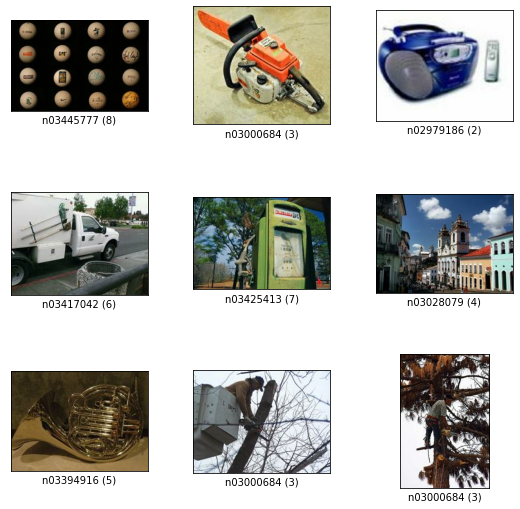

In [2]:
datasets, datasets_info = tfds.load('imagenette/160px', shuffle_files=True, as_supervised=True, with_info=True)
train_dataset, validation_dataset = datasets['train'], datasets['validation']
fig = tfds.show_examples(train_dataset, datasets_info)

In [3]:
def preprocessing(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image - MEAN_RGB
    image = image / STDDEV_RGB
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_dataset = (train_dataset.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(BATCH_SIZE)
                              .prefetch(tf.data.experimental.AUTOTUNE))

validation_dataset = (validation_dataset.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                        .batch(BATCH_SIZE)
                                        .prefetch(tf.data.experimental.AUTOTUNE))

## Define a floating-point model

In [4]:
def residual_conv_block(filters, stage, block, strides=(1, 1), cut='pre'):
    def layer(input_tensor):
        x = layers.BatchNormalization(epsilon=2e-5)(input_tensor)
        x = layers.Activation('relu')(x)

        # defining shortcut connection
        if cut == 'pre':
            shortcut = input_tensor
        elif cut == 'post':
            shortcut = layers.Conv2D(filters, (1, 1), strides=strides, kernel_initializer='he_uniform', 
                                     use_bias=False)(x)

        # continue with convolution layers
        x = layers.ZeroPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(filters, (3, 3), strides=strides, kernel_initializer='he_uniform', use_bias=False)(x)

        x = layers.BatchNormalization(epsilon=2e-5)(x)
        x = layers.Activation('relu')(x)
        x = layers.ZeroPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(filters, (3, 3), kernel_initializer='he_uniform', use_bias=False)(x)

        # add residual connection
        x = layers.Add()([x, shortcut])
        return x

    return layer


def ResNet18(input_shape=None):
    """Instantiates the ResNet18 architecture."""
    img_input = layers.Input(shape=input_shape, name='data')

    # ResNet18 bottom
    x = layers.BatchNormalization(epsilon=2e-5, scale=False)(img_input)
    x = layers.ZeroPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_uniform', use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=2e-5)(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    # ResNet18 body
    repetitions=(2, 2, 2, 2)
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            filters = 64 * (2 ** stage)
            if block == 0 and stage == 0:
                x = residual_conv_block(filters, stage, block, strides=(1, 1), cut='post')(x)
            elif block == 0:
                x = residual_conv_block(filters, stage, block, strides=(2, 2), cut='post')(x)
            else:
                x = residual_conv_block(filters, stage, block, strides=(1, 1), cut='pre')(x)
    x = layers.BatchNormalization(epsilon=2e-5)(x)
    x = layers.Activation('relu')(x)

    # ResNet18 top
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(NUM_CLASSES)(x)
    x = layers.Activation('softmax')(x)

    # Create model
    model = models.Model(img_input, x)

    return model

IMG_SHAPE = IMG_SIZE + (3,)
model = ResNet18(input_shape=IMG_SHAPE)

## Pre-train floating-point model

Using NNCF for model compression assumes that the user has a pre-trained model and a training pipeline.

> **NOTE** For the sake of simplicity of the tutorial, we propose to skip FP32 model training and load the weights that are provided.

In [7]:
# Load the floating-point weights
model.load_weights(fp32_h5_path)

# Compile the floating-point model
model.compile(metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc@1')])

# Validate the floating-point model
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"\nAccuracy of FP32 model: {test_acc:.3f}")

4/4 [==============================] - 1s 51ms/step - loss: 0.0000e+00 - acc@1: 0.3705

Accuracy of FP32 model: 0.376


Save the floating-point model to the frozen graph, which will be later used for conversion to OpenVINO IR and further performance measurement.

In [11]:
# def export_model_to_frozen_graph(model, output_dir, model_name):
#     # Convert Keras model to the frozen graph.
#     input_signature = []
#     for item in model.inputs:
#         input_signature.append(tf.TensorSpec(item.shape, item.dtype, item.name))
#     concrete_function = tf.function(model).get_concrete_function(input_signature)
#     frozen_func = convert_variables_to_constants_v2(concrete_function, lower_control_flow=False)
#     frozen_graph = frozen_func.graph.as_graph_def(add_shapes=True)
    
#     tf.io.write_graph(frozen_graph, output_dir, model_name, as_text=False)


# export_model_to_frozen_graph(model, OUTPUT_DIR, fp32_pb_name)

model.save(fp32_sm_path)

INFO:tensorflow:Assets written to: output/ResNet-18_fp32_saved_model/assets


INFO:tensorflow:Assets written to: output/ResNet-18_fp32_saved_model/assets


## Create and initialize quantization

NNCF enables compression-aware training by integrating into regular training pipelines. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires only 3 modifications.

1. Configure NNCF parameters to specify compression

In [12]:
nncf_config_dict = {
    "input_info": {"sample_size": [1, 3] + list(IMG_SIZE)},
    "log_dir": str(OUTPUT_DIR),  # log directory for NNCF-specific logging outputs
    "compression": {
        "algorithm": "quantization",  # specify the algorithm here
    },
}
nncf_config = NNCFConfig.from_dict(nncf_config_dict)

2. Provide data loader to initialize the values of quantization ranges and determine which activation should be signed or unsigned from the collected statistics using a given number of samples.

In [13]:
nncf_config = register_default_init_args(nncf_config=nncf_config,
                                         data_loader=train_dataset,
                                         batch_size=BATCH_SIZE)

3. Create a wrapped model ready for compression fine-tuning from a pre-trained FP32 model and configuration object.

In [14]:
compression_ctrl, model = create_compressed_model(model, nncf_config, None)

INFO:nncf:Creating compression algorithm: quantization
INFO:nncf:Collecting tensor statistics/data ████████          | 1 / 2
INFO:nncf:Collecting tensor statistics/data ████████████████  | 2 / 2
INFO:nncf:BatchNorm statistics adaptation █                 | 1 / 16
INFO:nncf:BatchNorm statistics adaptation ██                | 2 / 16
INFO:nncf:BatchNorm statistics adaptation ███               | 3 / 16
INFO:nncf:BatchNorm statistics adaptation ████              | 4 / 16
INFO:nncf:BatchNorm statistics adaptation █████             | 5 / 16
INFO:nncf:BatchNorm statistics adaptation ██████            | 6 / 16
INFO:nncf:BatchNorm statistics adaptation ███████           | 7 / 16
INFO:nncf:BatchNorm statistics adaptation ████████          | 8 / 16
INFO:nncf:BatchNorm statistics adaptation █████████         | 9 / 16
INFO:nncf:BatchNorm statistics adaptation ██████████        | 10 / 16
INFO:nncf:BatchNorm statistics adaptation ███████████       | 11 / 16
INFO:nncf:BatchNorm statistics adaptation ██

Evaluate the new model on the validation set after initialization of quantization. The accuracy should be not far from the accuracy of the floating-point FP32 model for a simple case like the one we are demonstrating now.

In [11]:
# Compile the int8 model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc@1')])

# Validate the int8 model
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"\nAccuracy of INT8 model after initialization: {test_acc:.3f}")

4/4 [==============================] - 1s 77ms/step - loss: 2.8547 - acc@1: 0.3809

Accuracy of INT8 model after initialization: 0.380


## Fine-tune the compressed model

At this step, a regular fine-tuning process is applied to restore accuracy drop. Normally, several epochs of tuning are required with a small learning rate, the same that is usually used at the end of the training of the original model. No other changes in the training pipeline are required. Here is a simple example.

In [12]:
# Train the int8 model
model.fit(train_dataset,
          epochs=1)

# Validate the int8 model
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"\nAccuracy of INT8 model after fine-tuning: {test_acc:.3f}")

4/4 [==============================] - 0s 69ms/step - loss: 1.6173 - acc@1: 0.5980

Accuracy of INT8 model after fine-tuning: 0.598


Save the INT8 model to the frozen graph, which will be later used for conversion to OpenVINO IR and further performance measurement.

In [13]:
export_model_to_frozen_graph(model, OUTPUT_DIR, int8_pb_name)

## Export Frozen Graph models to OpenVINO™ Intermediate Representation (IR)

Call the OpenVINO Model Optimizer tool to convert the Frozen Graph model to OpenVINO IR. The models are saved to the current directory.

See the [Model Optimizer Developer Guide](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) for more information about Model Optimizer.

Executing this command may take a while. There may be some errors or warnings in the output. Model Optimization successfully export to IR if the last lines of the output include: `[ SUCCESS ] Generated IR version 10 model`

In [26]:
if not fp32_ir_path.exists():
    !mo  --framework=tf --reverse_input_channels --input_shape=[1,224,224,3] --input=Placeholder --saved_model_dir==$fp32_sm_path --output_dir=$OUTPUT_DIR

[ ERROR ]  The "=output/ResNet-18_fp32_saved_model" is not existing directory


In [27]:
print(str(fp32_sm_path)) 

!ls $fp32_sm_path

output/ResNet-18_fp32_saved_model
assets	saved_model.pb	variables


In [ ]:
"/home/negvet/openvino_notebooks/notebooks/305-tensorflow-quantization-aware-training/output/ResNet-18_fp32_saved_model/"

In [15]:
if not int8_ir_path.exists():
    !mo  --framework=tf --reverse_input_channels --input_shape=[1,224,224,3] --input=Placeholder --input_model=$int8_pb_path --output_dir=$OUTPUT_DIR

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/negvet/openvino_notebooks/notebooks/305-tensorflow-quantization-aware-training/output/ResNet-18_int8.pb
	- Path for generated IR: 	/home/negvet/openvino_notebooks/notebooks/305-tensorflow-quantization-aware-training/output
	- IR output name: 	ResNet-18_int8
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Placeholder
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,224,224,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	True
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation

## Benchmark model performance by computing inference time

Finally, we will measure the inference performance of the FP32 and INT8 models. To do this, we use [Benchmark Tool](https://docs.openvinotoolkit.org/latest/openvino_inference_engine_tools_benchmark_tool_README.html) - OpenVINO's inference performance measurement tool. By default, Benchmark Tool runs inference for 60 seconds in asynchronous mode on CPU. It returns inference speed as latency (milliseconds per image) and throughput (frames per second) values.

> **NOTE**: In this notebook we run benchmark_app for 15 seconds to give a quick indication of performance. For more accurate performance, we recommended running benchmark_app in a terminal/command prompt after closing other applications. Run benchmark_app -m model.xml -d CPU to benchmark async inference on CPU for one minute. Change CPU to GPU to benchmark on GPU. Run benchmark_app --help to see an overview of all command line options.

In [16]:
def parse_benchmark_output(benchmark_output):
    parsed_output = [line for line in benchmark_output if not (line.startswith(r"[") or line.startswith("  ") or line == "")]
    print(*parsed_output, sep='\n')


print('Benchmark FP32 model (IR)')
benchmark_output = ! benchmark_app -m $fp32_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

print('\nBenchmark INT8 model (IR)')
benchmark_output = ! benchmark_app -m $int8_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

Benchmark FP32 model (IR)
Count:      7014 iterations
Duration:   15019.35 ms
Latency:    12.84 ms
Throughput: 467.00 FPS

Benchmark INT8 model (IR)
Count:      24222 iterations
Duration:   15003.02 ms
Latency:    3.65 ms
Throughput: 1614.48 FPS


Show CPU Information for reference

In [17]:
try:
    import cpuinfo

    print(cpuinfo.get_cpu_info()["brand_raw"])
except Exception:
    # OpenVINO installs cpuinfo, but if a different version is installed
    # the command above may not work
    print(platform.processor())

Intel(R) Core(TM) i9-10920X CPU @ 3.50GHz
